In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pmdarima.arima import ndiffs, nsdiffs
from datetime import datetime
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from dateutil.relativedelta import relativedelta
from metricas import calculo_metricas

import warnings
warnings.simplefilter("ignore")

# Mostramos las versiones de los módulos para posibles reproducciones del código

print('Versión pandas:', pd.__version__)
print('Versión numpy:', np.__version__)
print('Versión matplotlib:', matplotlib.__version__)
print('Version statsmodels', sm.__version__)

Versión pandas: 1.0.5
Versión numpy: 1.19.5
Versión matplotlib: 3.2.2
Version statsmodels 0.12.2


In [2]:
df = pd.read_csv('Data/dataframe.csv', index_col = 0)
df.index = pd.to_datetime(df.index)
#df = df.drop(columns = ["Festivo_Regional", "Humedad_Relativa", "Precipitacion", "Radiacion", "Velocidad_Viento"])

df.loc[:, "lag_24"] = df.Spot_electricidad.shift(24)
df.loc[:, "lag_48"] = df.Spot_electricidad.shift(48)
df.loc[:, "lag_1_semana"] = df.Spot_electricidad.shift(24*7)

Diferencia regular: 0
Diferencia estacional: 0


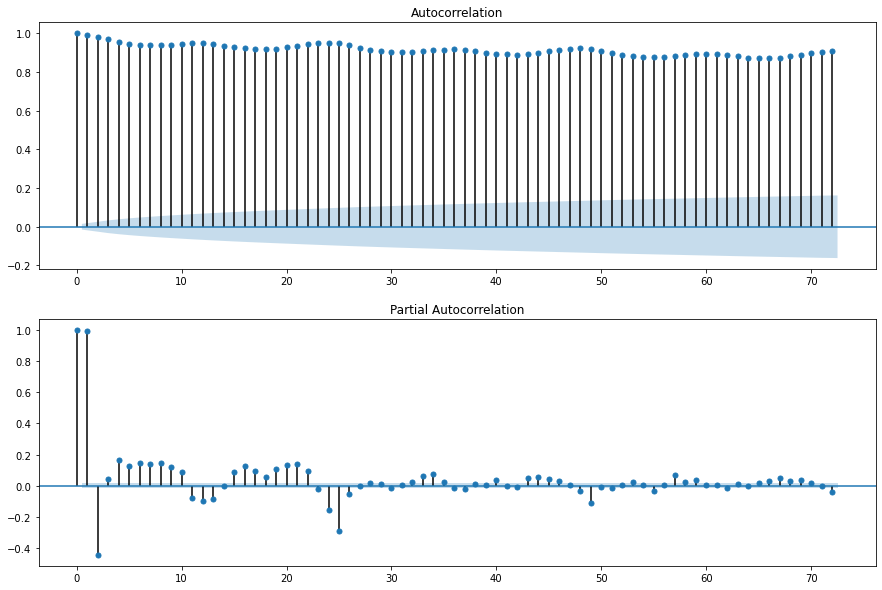

In [3]:
y = df.Spot_electricidad.loc["2020":]
nlags = 72
print('Diferencia regular:', ndiffs(y, alpha = 0.05, test = 'adf'))
print('Diferencia estacional:', nsdiffs(y, m = 24, test = 'ocsb'))
fig, ax = plt.subplots(2,1, figsize = (15,10))
plot_acf(y, lags = nlags,  ax=ax[0])
plot_pacf(y, lags = nlags, method="ols",ax=ax[1])
plt.show()

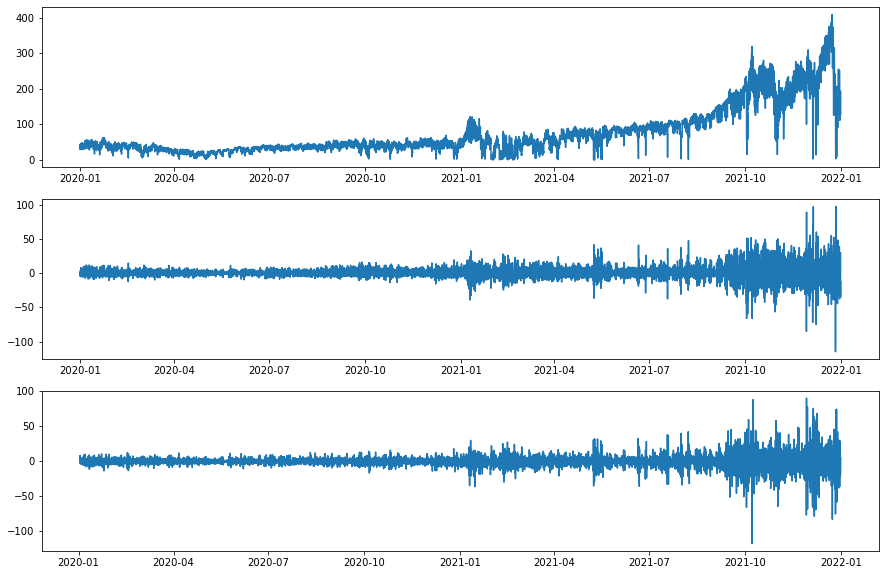

0.0048982500142506985 -0.002945944403219359


In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (15,10))
ax1.plot(y)
ax2.plot(y.diff(1).dropna())
ax3.plot(y.diff(24).diff(1).dropna())
plt.show()

print(y.diff(1).dropna().mean(), y.diff(24).diff(1).dropna().mean())

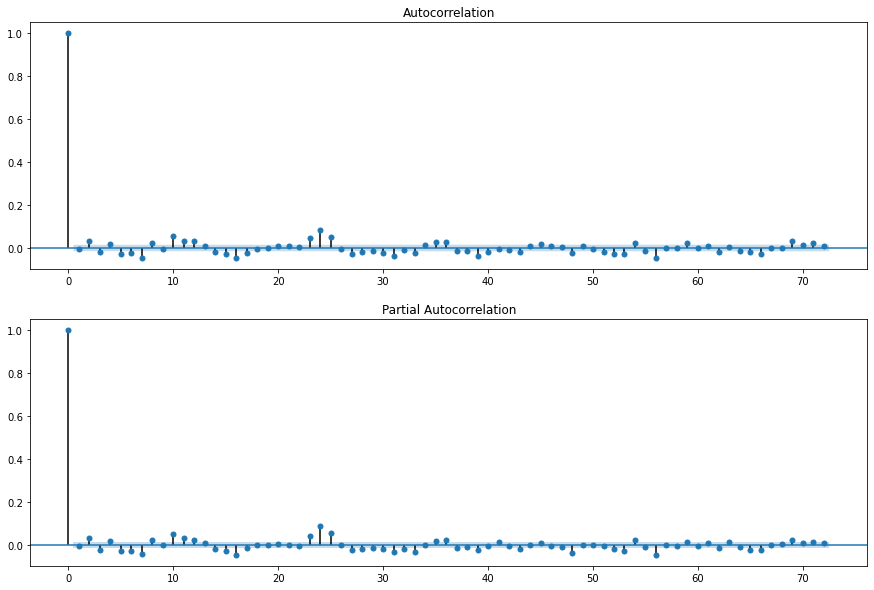

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
modelo = SARIMAX(endog = y, order = (2,1,1), seasonal_order= (0,1,1,24)).fit(method = 'lbfgs', disp = False)

fig, ax = plt.subplots(2,1, figsize = (15,10))
plot_acf(modelo.resid, lags = nlags,  ax=ax[0])
plot_pacf(modelo.resid, lags = nlags, method="ols",ax=ax[1])
plt.show()

### SARIMA

In [6]:
def bascktesting_sarima(db, año, mes, rolling_window, days_start):
    fecha = datetime(año, mes, 1)
    fecha_str = str(año) + '-' + str(mes) + '-' + str(1)
    
    array_real, array_pred, array_date = np.zeros(len(db.loc[fecha_str:])), np.zeros(len(db.loc[fecha_str:])), []
    
    fecha = datetime(año, mes, 1)
    fecha_str = str(año) + '-' + str(mes) + '-' + str(1)
    
    db = db.dropna()
    array_real, array_pred, array_date = np.zeros(len(db.loc[fecha_str:])), np.zeros(len(db.loc[fecha_str:])), []

    # En caso de que haya rolling window
    if rolling_window == True:
        for day in range(int(len(db.loc[fecha_str:]) / 24)):
            fecha_end_train = fecha + relativedelta(days = day)
            fecha_start_train = fecha_end_train - relativedelta(days = days_start)
            fecha_end_train = str(fecha_end_train.year) + "-" + str(fecha_end_train.month) + "-" + str(fecha_end_train.day)
            fecha_start_train = str(fecha_start_train.year) + "-" + str(fecha_start_train.month) + "-" + str(fecha_start_train.day)
            db_aux = db.loc[fecha_start_train:fecha_end_train]
            
            # Dataframe de Entrenamiento
            y_train = db_aux
            
            # Dataframe de Test
            y_test = y_train.pop(fecha_end_train)

            # Entrenamos el modelo
            model = SARIMAX(endog = y_train, order = (2,1,1), seasonal_order= (0,1,1,24)).fit(method = 'lbfgs', disp = False)
            pred = model.forecast(24)
            date = [str(i) for i in pred.index]
            array_date.append(date)
            array_pred[day*24:day*24 + 24] = pred.values
            array_real[day*24:day*24 + 24] = y_test
            print(day)

            
        
    # En caso de que no haya rolling window, siempre cogemos todo el dataframe disponible
    else:
        for day in range(int(len(db.loc[fecha_str:]) / 24)):
            fecha_end_train = fecha + relativedelta(days = day)
            fecha_end_train = str(fecha_end_train.year) + "-" + str(fecha_end_train.month) + "-" + str(fecha_end_train.day)
            db_aux = db.loc[:fecha_end_train]

            # Dataframe de Entrenamiento
            X_train = sm.add_constant(db_aux)
            y_train = X_train.pop('Price')
            
            # Dataframe de Test
            X_test = X_train.loc[fecha_end_train]
            y_test = y_train.pop(fecha_end_train)
            
            # Quitamos al dataframe de train, el dataframe de test
            X_train = X_train.drop(index = X_train.iloc[-24:].index)
            
            # Entrenamos el modelo
            model = SARIMAX(endog = y_train, order = (2,1,1), seasonal_order= (0,1,1,24)).fit(method = 'lbfgs', disp = False)

            pred = model.forecast(24, exog = X_test)
            
            date = [str(i) for i in pred.index]
            array_date.append(date)
            array_pred[day*24:day*24 + 24] = pred.values
            array_real[day*24:day*24 + 24] = y_test
            print(day)
            
    array_date = [item for sublist in array_date for item in sublist]
    return array_pred, array_real, array_date

    
pred, real, dates = bascktesting_sarima(y, 2021, 1, rolling_window = True, days_start = 90)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [7]:
resultados = pd.DataFrame({"Pred":pred, "Real":real}, index = dates)
resultados["Pred"][resultados.loc[:, "Pred"] < 0] = 0
resultados.index = pd.to_datetime(resultados.index)
sarima, sarima_metricas_mensuales, met = calculo_metricas(resultados)

    MAE  MAE (median)    MAPE  WMAPE   RMSE  % Trend
0  14.3          8.79  148.62  12.78  23.11    82.76


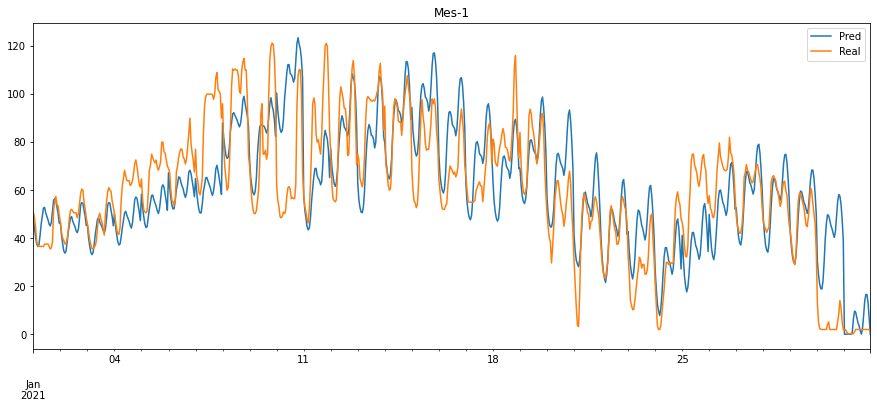

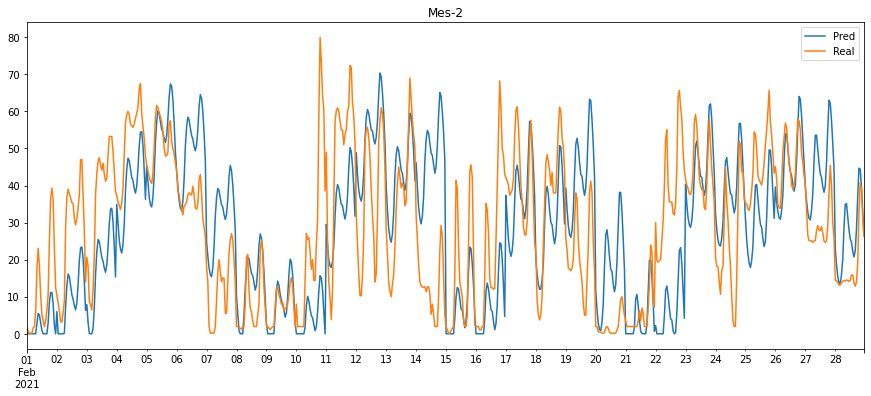

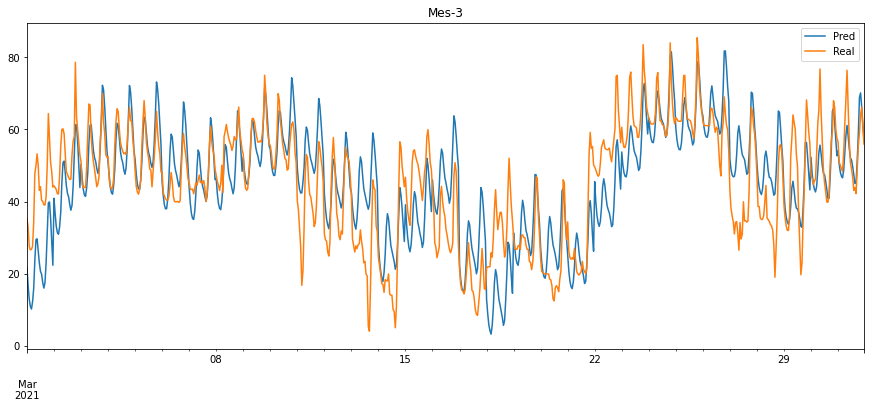

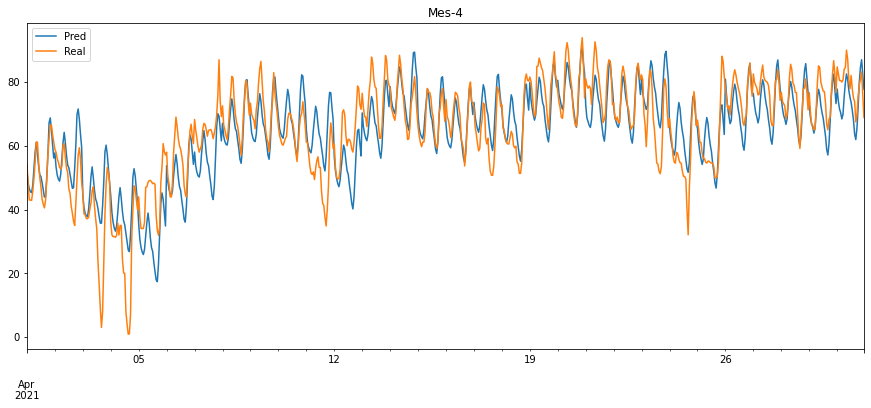

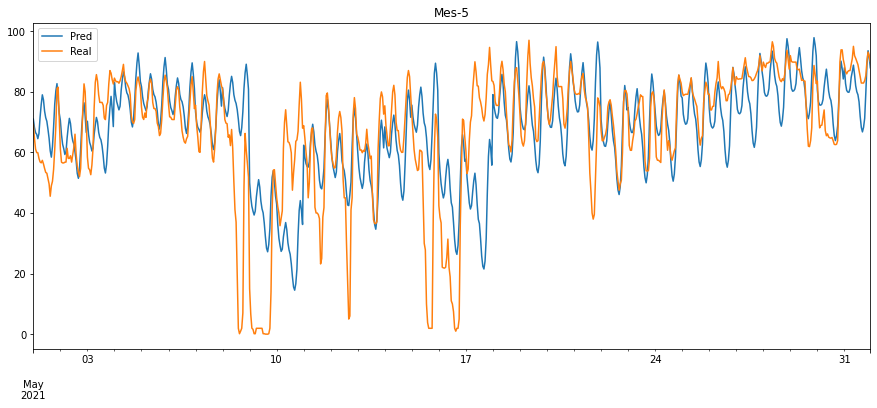

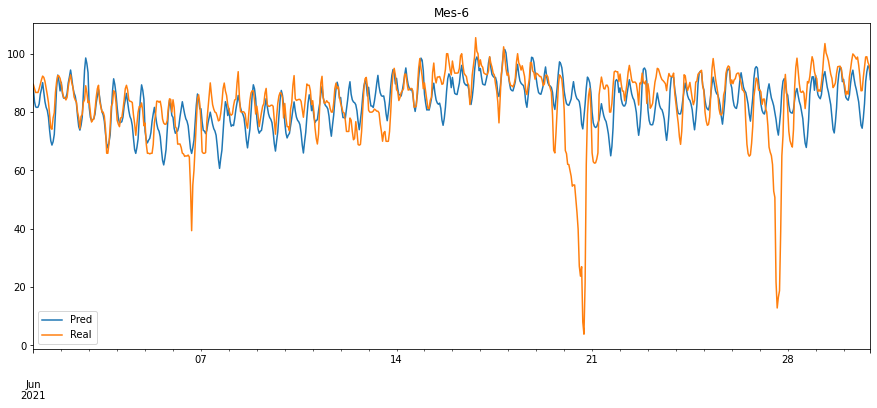

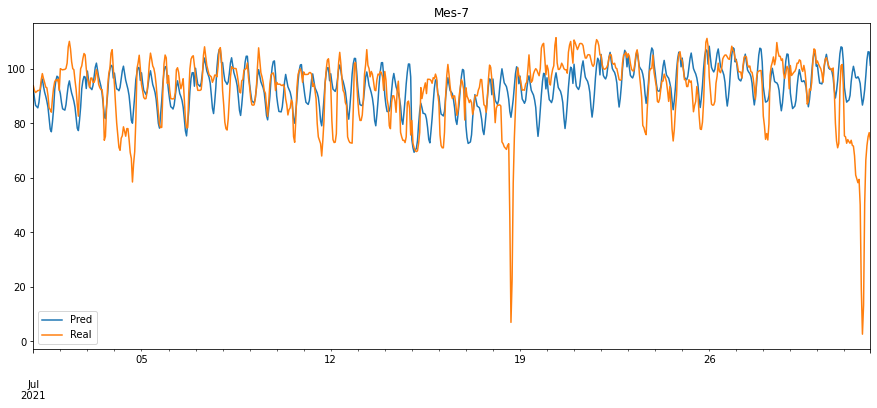

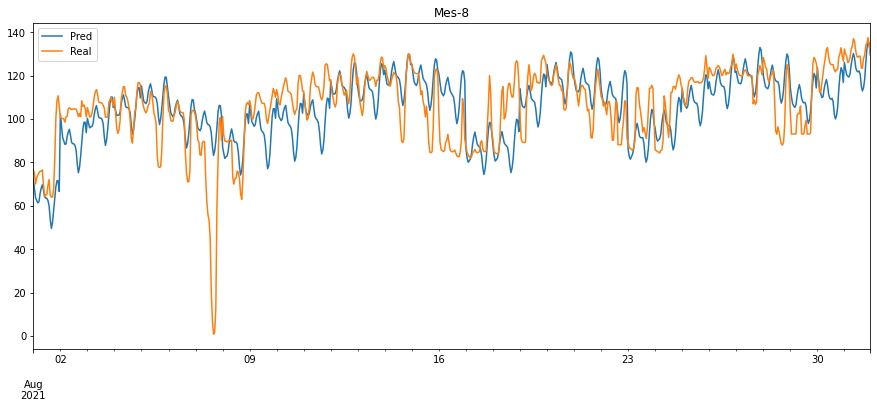

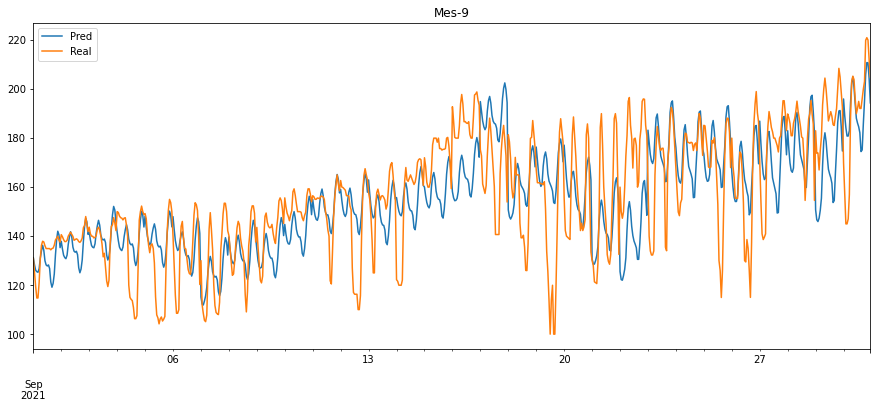

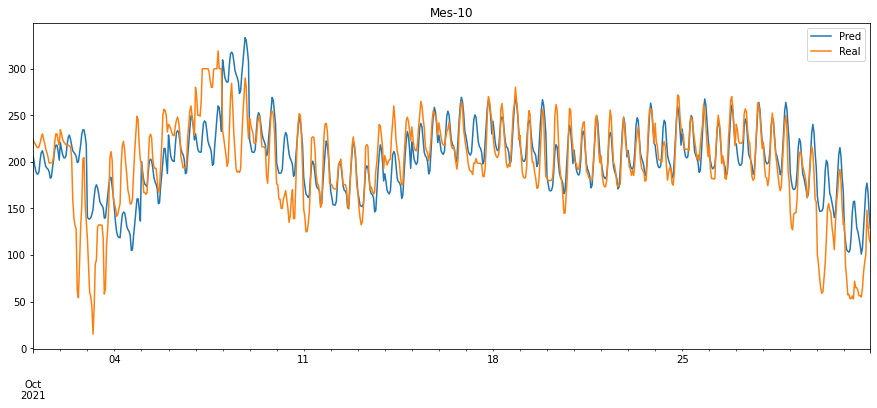

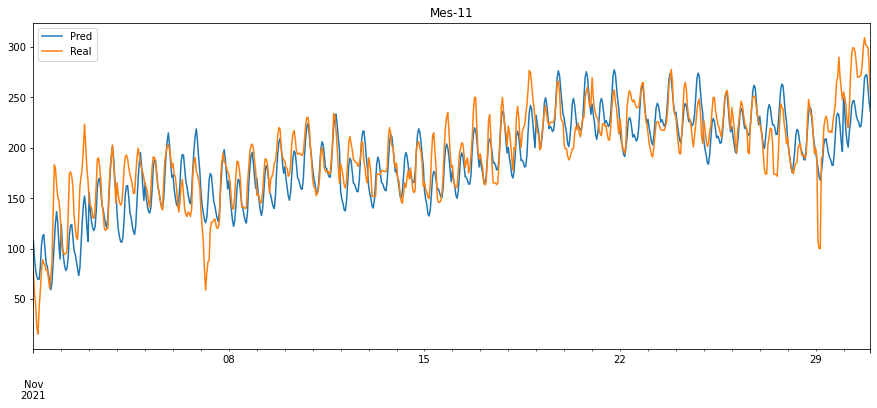

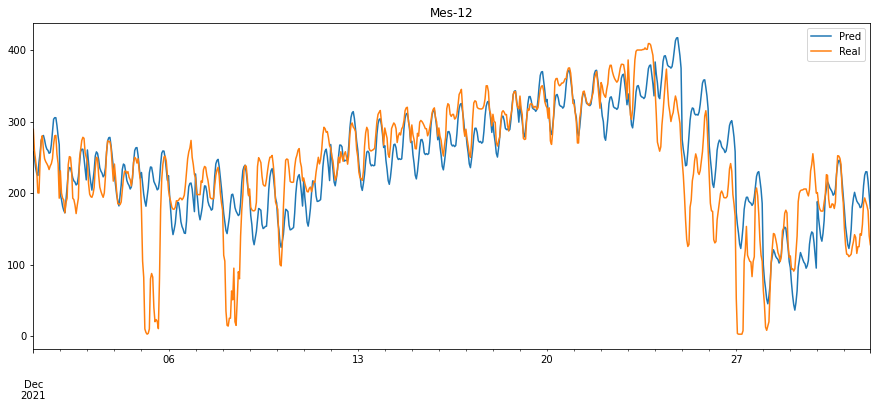

In [8]:
def plot_meses(df):
    for i in range(1,13):
        fecha = "2021-" + str(i)
        df.loc[fecha][["Pred", "Real"]].plot(figsize=(15,6))
        plt.title('Mes-' + str(i))
        
plot_meses(sarima)

In [9]:
sarima.to_csv('Resultados/sarima_90.csv')

In [10]:
reg_lin = pd.read_csv('Resultados/resultados_reg_lineal.csv', index_col = 0)
reg_lin.index = pd.to_datetime(reg_lin.index)

In [11]:
pred = (sarima.Pred + reg_lin.Pred) / 2

In [12]:
aux = pd.DataFrame({'Pred': pred, 'Real' : real}, index = dates)
aux.index = pd.to_datetime(aux.index)

a,b,c = calculo_metricas(aux)

     MAE  MAE (median)    MAPE  WMAPE   RMSE  % Trend
0  10.97          6.86  133.61    9.8  18.27    84.27


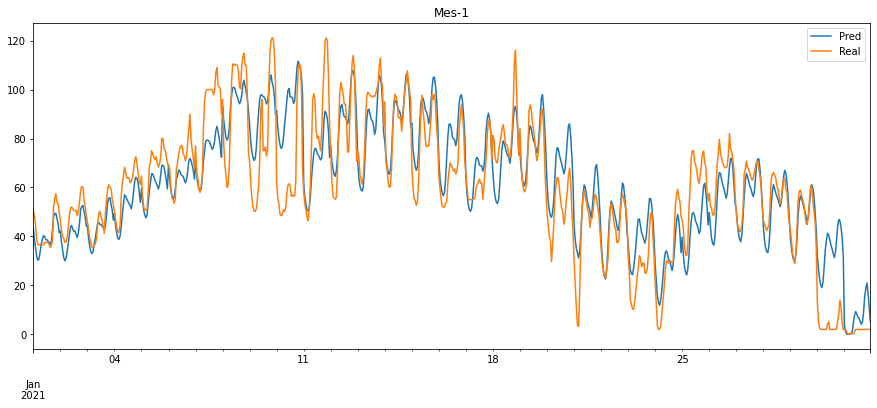

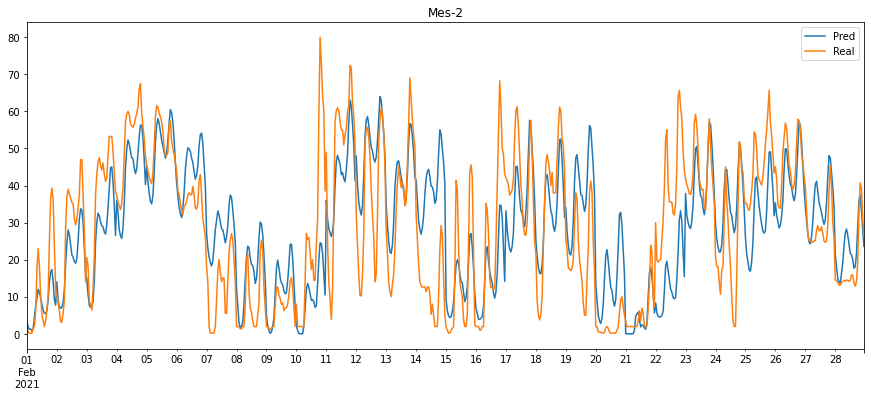

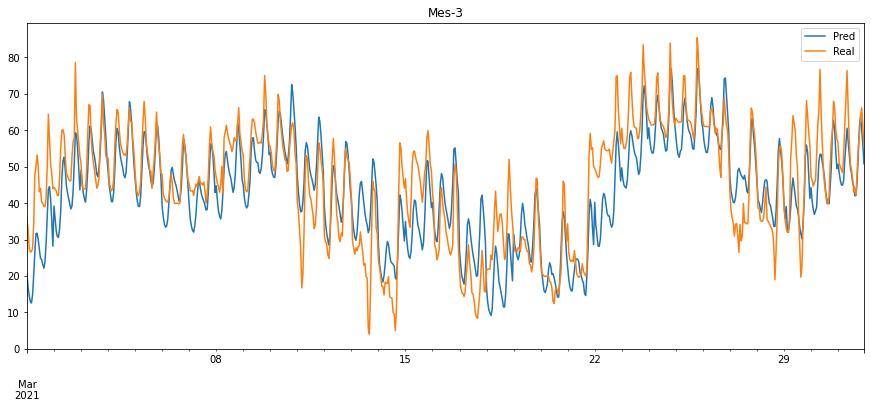

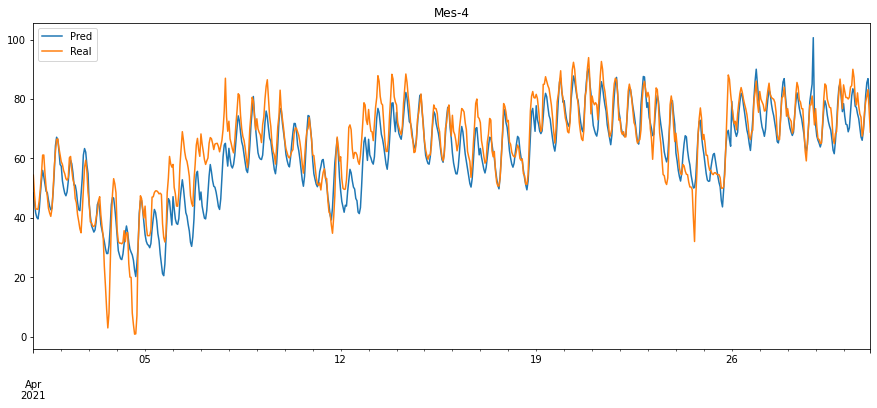

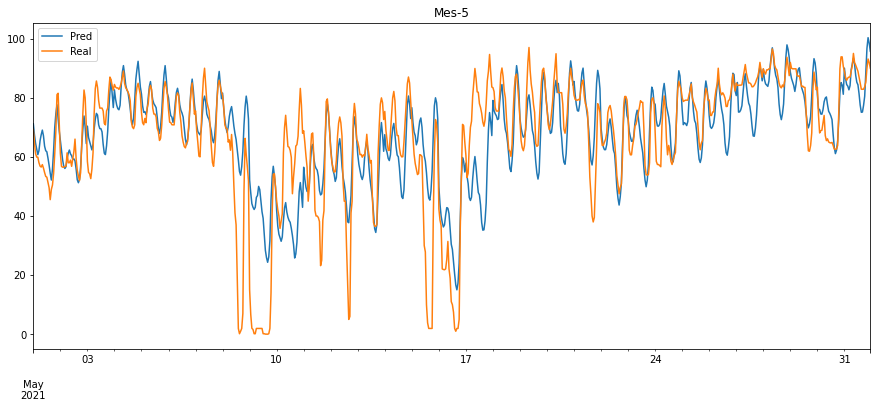

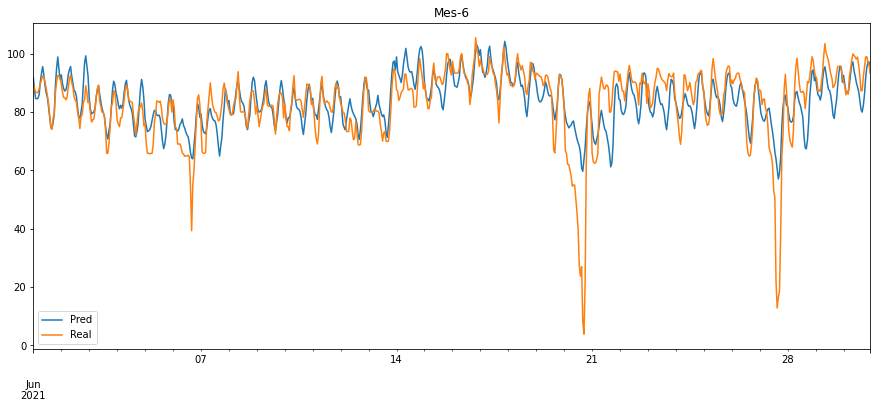

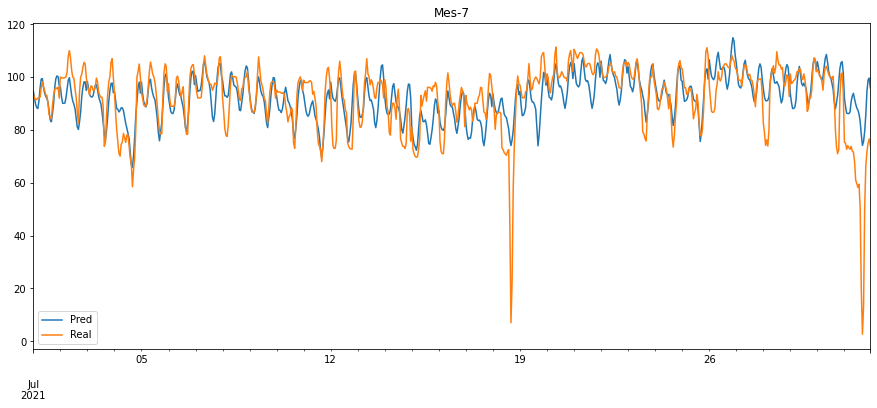

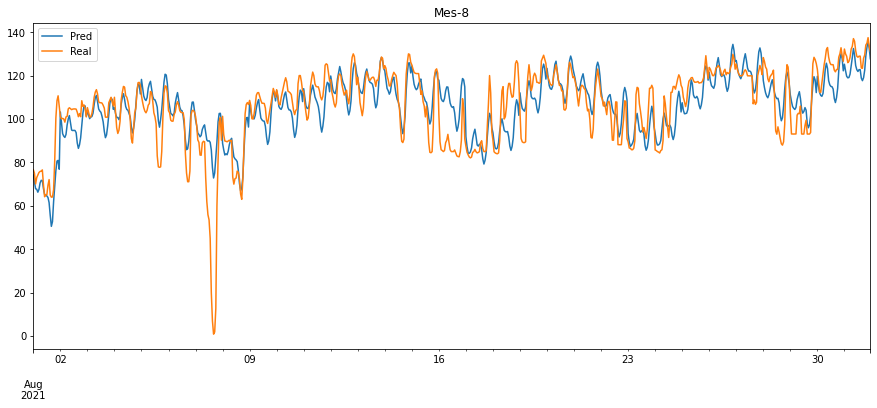

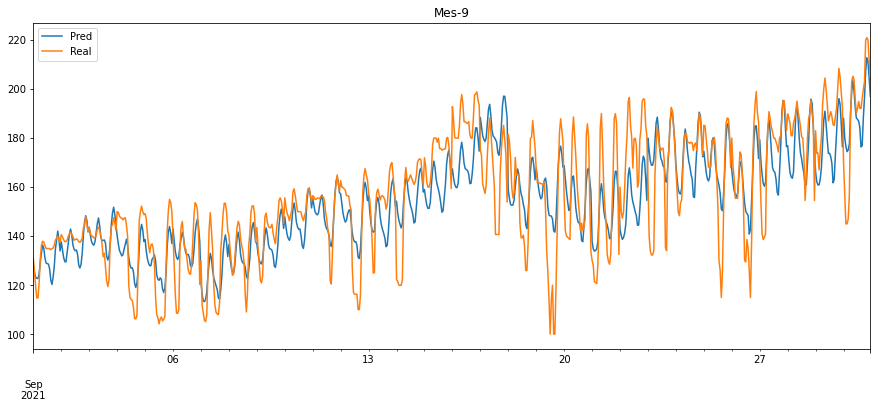

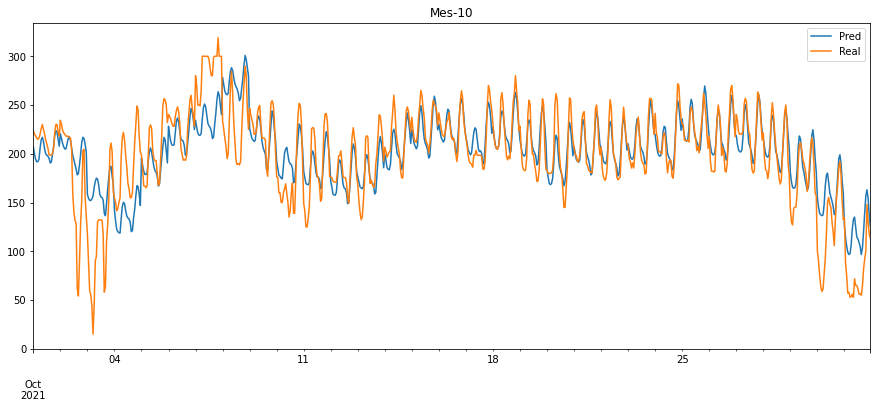

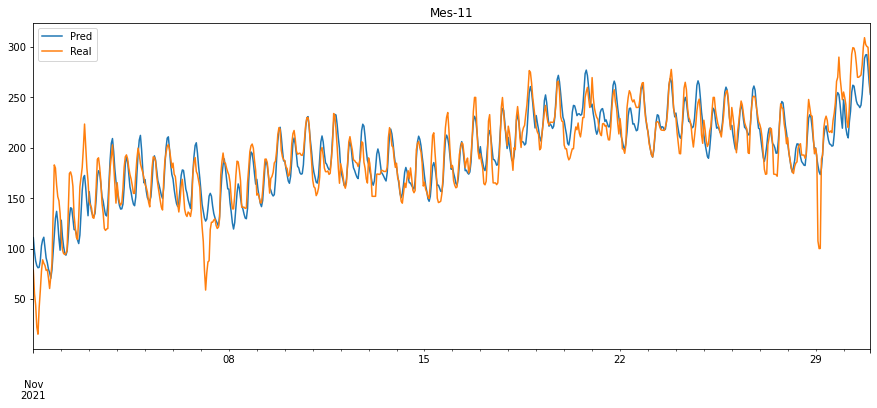

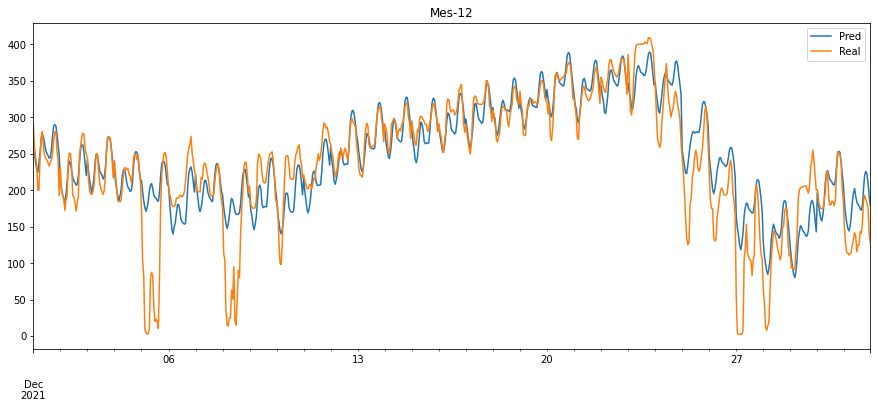

In [13]:
plot_meses(aux)